# I. Importations des modules et des données
## 1.1 Importation des modules

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from zipfile import ZipFile
import shutil
import glob
from termcolor import colored

yellow = '\033[93m'
green = '\033[92m'
red = '\033[91m'
blue = '\033[94m'

## 1.2 Extraction des données

In [2]:
allow_extraction = False
datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets"
extracted_datasets_path = os.path.join(datasets_path,'Extracted')
new_dataset_filename = "Other"
new_dataset_path = os.path.join(extracted_datasets_path, new_dataset_filename)
datasets_to_regroup = ['Dataset','Painting','Schematics','Sketch','Text']

if allow_extraction:
    try:
        for dataset_filename in os.listdir(datasets_path):

            dataset_path = os.path.join(datasets_path, dataset_filename)
            dataset_zip = ZipFile(dataset_path, 'r')

            if not os.path.exists(extracted_datasets_path):
                os.makedirs(extracted_datasets_path)
                print(f"Extraction folder successfully created at '{extracted_datasets_path}'")

            print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
            dataset_zip.extractall(extracted_datasets_path)
            print(f"'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")

        dataset_zip.close()
    except:
        pass
    
    if not os.path.exists(new_dataset_path):
        os.makedirs(new_dataset_path)
        print(f"New folder successfully created at '{new_dataset_path}'")
    for dataset in os.listdir(extracted_datasets_path):
        if dataset in datasets_to_regroup:
            dataset_directory = os.path.join(extracted_datasets_path, dataset)
            print(f"Starting the copy of '{dataset_directory}' at '{new_dataset_path}'")
            shutil.copytree(dataset_directory, new_dataset_path, copy_function=shutil.move, dirs_exist_ok=True)
            print(f"'The content of {dataset_directory}' was successfully extracted at '{new_dataset_path}'")
            shutil.rmtree(dataset_directory)

## 1.3 Pré-traitement des données

### Recherche d'images  corrompues et rotation des images

In [3]:
allow_search_for_corrupted = False
allow_rotation = False

images_width=[]
images_height=[]

if allow_search_for_corrupted:
    img_paths = glob.glob(os.path.join(r"C:\Users\axelb\Desktop\Projet DS\Datasets\Extracted",'*/*.*')) # assuming you point to the directory containing the label folders.

    bad_paths = []

    for image_path in img_paths:
        try:
            img_bytes = tf.io.read_file(image_path)

            decoded_img = tf.io.decode_image(img_bytes)
            img_height = decoded_img.shape[0]
            img_width = decoded_img.shape[1]

            if img_width < img_height and allow_rotation:

                print(f"Rotating the image at {image_path}...")
                decoded_img = tf.image.rot90(decoded_img)
                img_height = decoded_img.shape[0]
                img_width = decoded_img.shape[1]
                
                img = tf.keras.utils.array_to_img(decoded_img)
                rgb_im = img.convert('RGB')
                rgb_im.save(image_path)

            images_width.append(img_width)
            images_height.append(img_height)    
            
        except tf.errors.InvalidArgumentError as e:
          print(f"Found bad path {image_path}...{e}")
          bad_paths.append(image_path)
            
    for bad_path in bad_paths:
        print(f"WARNING : Dropping the file at {bad_path} because it can't be open...")
        os.remove(bad_path)
        
print(f"The median of width is {np.median(images_width)}")
print(f"The median of height is {np.median(images_height)}")

The median of width is nan
The median of height is nan


C:\Users\axelb\anaconda3\envs\TensorflowGPU\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\axelb\anaconda3\envs\TensorflowGPU\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 1.4 Importation des données

In [4]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    extracted_datasets_path,
    validation_split=0.2,
    seed=10,
    image_size = (224, 224),
    batch_size=64,
    subset = "both"
)

print(f"\nThe dataset is composed of these classes : {train_set.class_names}")

for images, labels in train_set:
    print(f"\nThe dataset is composed of these classes : {images.shape}")
    print(f"The dataset is composed of these labels : {labels.shape}")
    break

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Using 8281 files for validation.

The dataset is composed of these classes : ['Other', 'Photo']

The dataset is composed of these classes : (64, 224, 224, 3)
The dataset is composed of these labels : (64,)


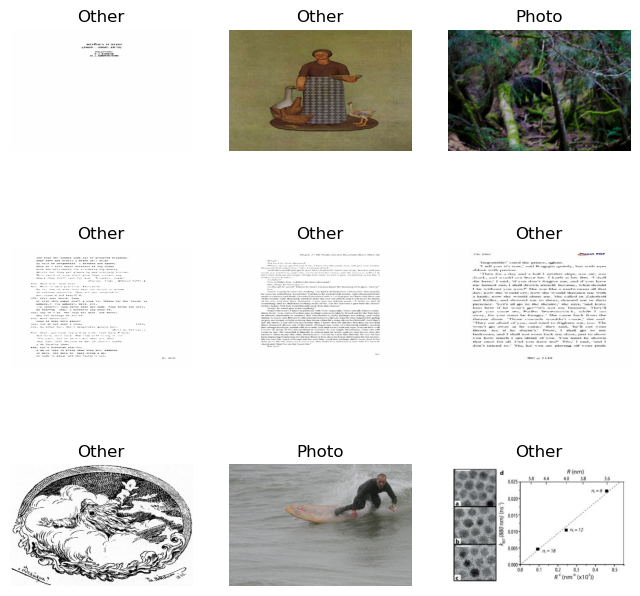

In [5]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[i]])
        plt.axis("off")
plt.show()

## 1.5 Augmentation des données

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation((0.2, 0.5),(0.2, 0.5)),
  tf.keras.layers.RandomZoom((0.2, 0.5)),
  tf.keras.layers.RandomContrast((0.2,0.5))
])

augmented_train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y))
print(augmented_train_set.cardinality())

tf.Tensor(259, shape=(), dtype=int64)


# 2. Modélisation des données
## 2.1 Définition du modèle

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## 2.2 Compilation du modèle 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

## 2.3 Entrainement du modèle

Epoch 1/10
518/518 [==============================] - 84s 161ms/step - loss: 0.2807 - accuracy: 0.8715 - val_loss: 0.2767 - val_accuracy: 0.8721
Epoch 2/10
518/518 [==============================] - 91s 174ms/step - loss: 0.2549 - accuracy: 0.8852 - val_loss: 0.2537 - val_accuracy: 0.8873
Epoch 3/10
518/518 [==============================] - 95s 181ms/step - loss: 0.2334 - accuracy: 0.8958 - val_loss: 0.2487 - val_accuracy: 0.8865
Epoch 4/10
518/518 [==============================] - 96s 184ms/step - loss: 0.2185 - accuracy: 0.9041 - val_loss: 0.2286 - val_accuracy: 0.9012
Epoch 5/10
518/518 [==============================] - 98s 187ms/step - loss: 0.2074 - accuracy: 0.9114 - val_loss: 0.2253 - val_accuracy: 0.9023
Epoch 6/10
518/518 [==============================] - 99s 188ms/step - loss: 0.1919 - accuracy: 0.9183 - val_loss: 0.2120 - val_accuracy: 0.9118
Epoch 7/10
518/518 [==============================] - 100s 190ms/step - loss: 0.1826 - accuracy: 0.9224 - val_loss: 0.2151 - val_a

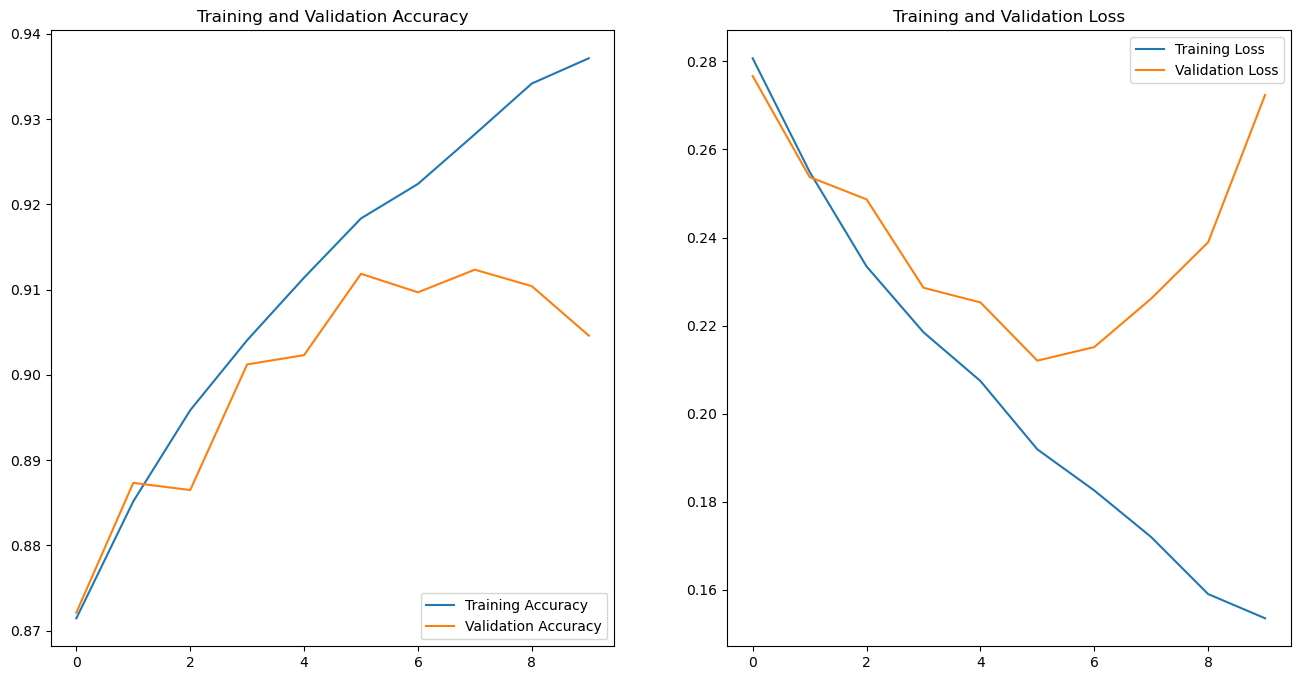

In [16]:
epochs1 = 10

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1)

history1 =  model.fit(
    #augmented_train_set,
    train_set,
    validation_data=test_set,
    epochs=epochs1,
    #callbacks=[callback]
)

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(history1.history['loss']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

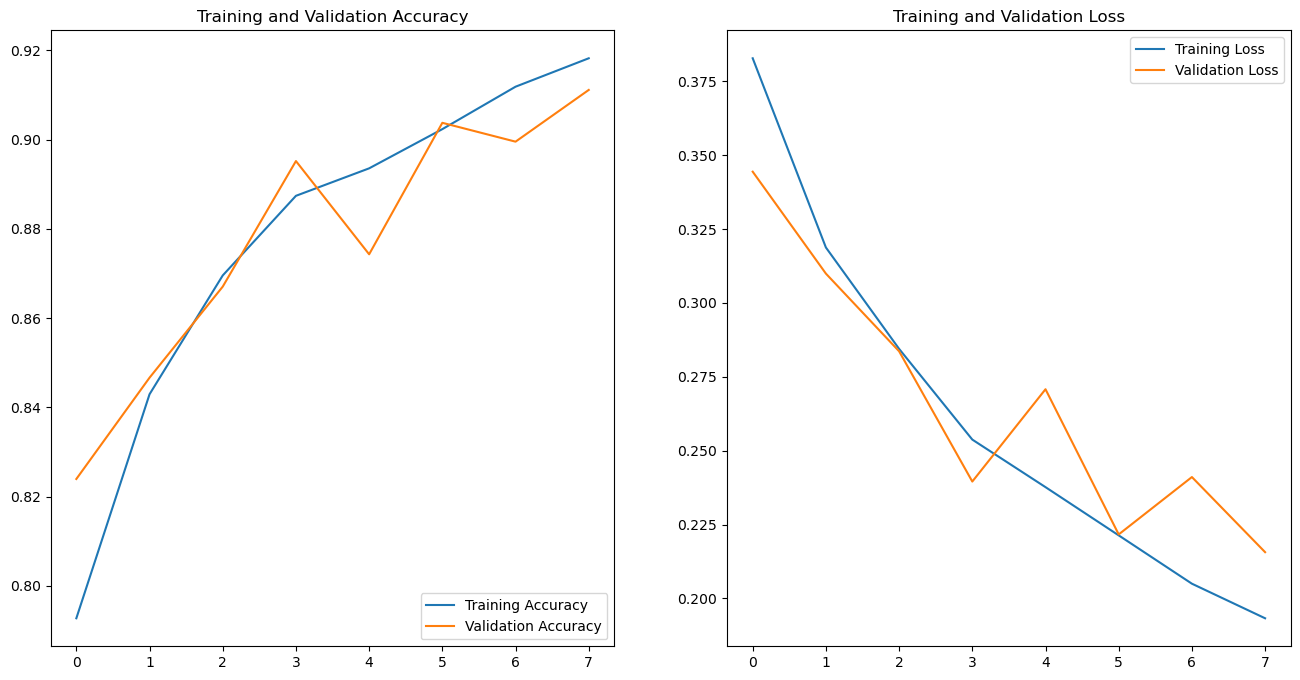

In [11]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(history1.history['loss']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10
518/518 [==============================] - 201s 385ms/step - loss: 0.1963 - accuracy: 0.9179 - val_loss: 0.2136 - val_accuracy: 0.9065
Epoch 2/10
518/518 [==============================] - 207s 397ms/step - loss: 0.1889 - accuracy: 0.9208 - val_loss: 0.2165 - val_accuracy: 0.9058
Epoch 3/10
518/518 [==============================] - 209s 401ms/step - loss: 0.1721 - accuracy: 0.9259 - val_loss: 0.2035 - val_accuracy: 0.9135
Epoch 4/10
518/518 [==============================] - 265s 510ms/step - loss: 0.1597 - accuracy: 0.9318 - val_loss: 0.2074 - val_accuracy: 0.9134
Epoch 5/10
518/518 [==============================] - 212s 407ms/step - loss: 0.1610 - accuracy: 0.9347 - val_loss: 0.2436 - val_accuracy: 0.9075
Epoch 6/10
518/518 [==============================] - 212s 407ms/step - loss: 0.1385 - accuracy: 0.9434 - val_loss: 0.2257 - val_accuracy: 0.9133
Epoch 7/10
518/518 [==============================] - 212s 407ms/step - loss: 0.1249 - accuracy: 0.9489 - val_loss: 0.2361 -

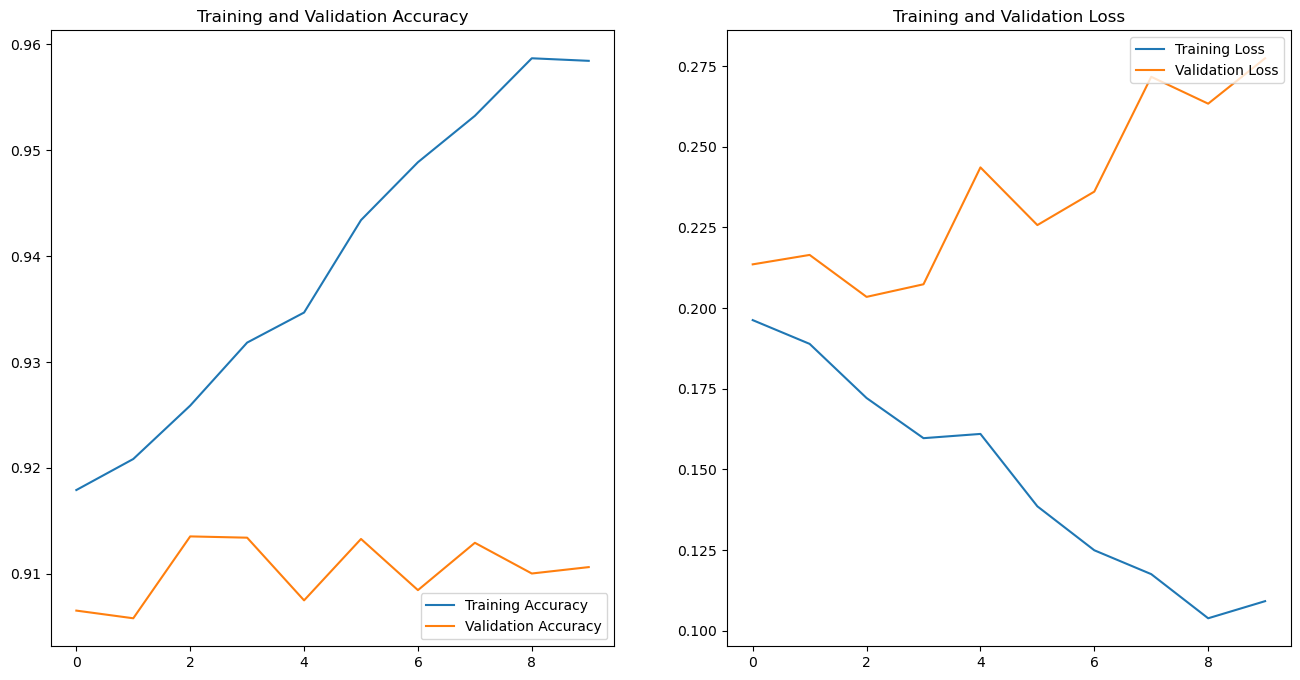

In [14]:
epochs2 = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,  patience=2, verbose=1, start_from_epoch=3)

history2 =  model.fit(
    #augmented_train_set,
    train_set,
    validation_data=test_set,
    epochs=epochs2,
    callbacks=[callback]
)

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs2)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

10
10
20


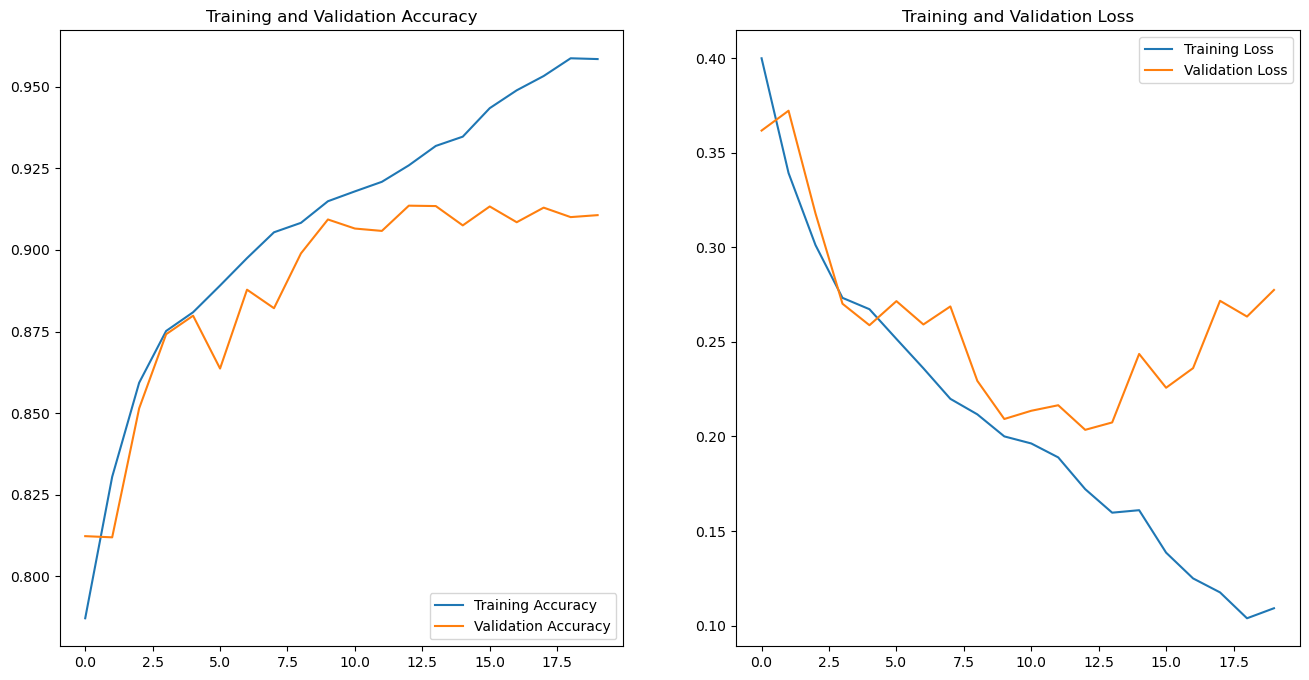

In [15]:
merged_history = ""
        
def merge_history(history1, history2):
    history = history1.history.copy()
    for key in history2.history:
        history[key] = history[key] + history2.history[key]
    return history

merged_history = merge_history(history1, history2)

print(len(history1.history['accuracy']))
print(len(history2.history['accuracy']))
print(len(merged_history['accuracy']))

acc = merged_history['accuracy']
val_acc = merged_history['val_accuracy']

loss = merged_history['loss']
val_loss = merged_history['val_loss']


epochs_range = range(epochs1+epochs2)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

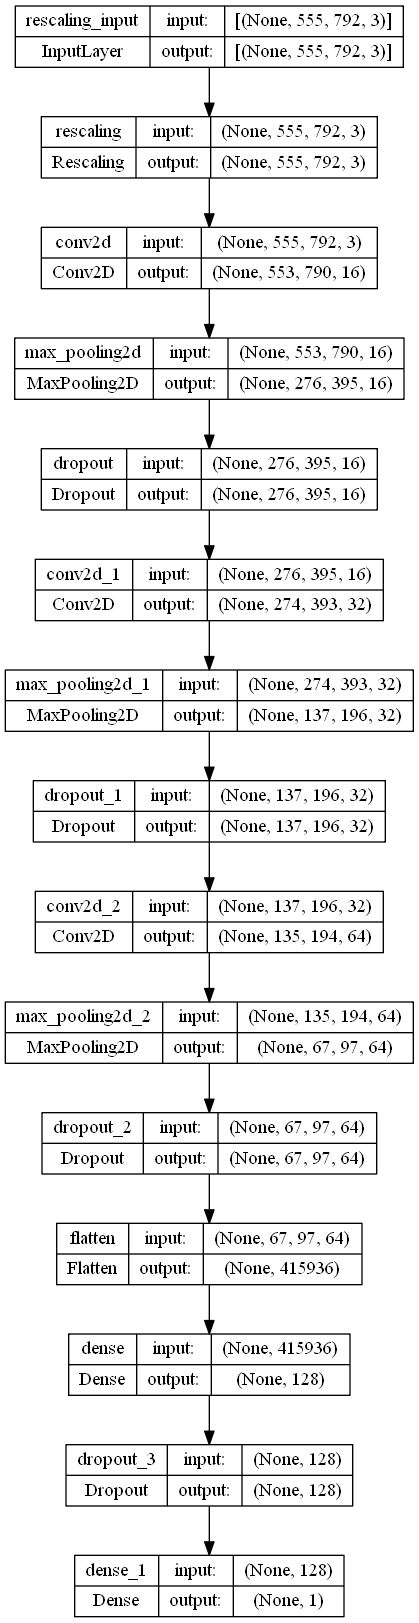

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)